# Introduction to the $\beta$-PDF
At a location in a given diffusion flame (i.e. known initial composition, strain, and time scale), the value of any flame parameter $\phi$ (e.g. $T$, $\rho$, etc.) is a function of the mixture fraction, $\xi$. $\xi$ is defined as what fraction of the mass in the flame originated from the fuel, with $\xi = 1$ corresponding to pure fuel. In order to create a tabular version of table parameters, we need to determine the average values of flame parameters. The general formula for the statistical average of a value $\phi = \phi(\xi)$ is given by
$$\int_{-\infty}^{\infty} \phi(\xi)*P(\xi)d\xi$$
where $P(\xi)$ is the probability distribution function desribing the probability of a given value of $\xi$ occurring. In a diffusion flame like the one used to model the flame's chemistry, the distribution of $\xi$ closely matches the shape of the $\beta$-PDF, given by:
$$f(x; \alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}~x^{\alpha-1}(1-x)^{\beta-1}$$

## Diffusive Mixing
Qualitatively, the $\beta$-PDF's behavior matches diffusive mixing:

In [ ]:
HTML('<img src="diffusion.gif">')

This result is achieve by setting the $\beta$-PDF parameters in terms of the mean mixture fraction $\bar{\xi}$ and the variance of the mixture fraction $\sigma^2_{\xi}$ as follows:
$$\alpha = \bar{\xi}~\left(\frac{\bar{\xi}(1-\bar{\xi})}{\sigma^2_{\xi}}-1\right)$$
$$\beta = (1-\bar{\xi})~\left(\frac{\bar{\xi}(1-\bar{\xi})}{\sigma^2_{\xi}}-1\right)$$

These parameter formulas can be derived using the method of moments [1].

### Diffusion Simulation Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
import LiuInt as LI
from IPython.display import HTML

import importlib
importlib.reload(LI)
%matplotlib inline

if input("Rerun simulation")=='y':
    #----- Model diffusive mixing
    # Parameters
    t_steps = 2000
    n_points = 500
    xmax = 100
    ymax = 10
    partitionLoc = int(xmax/2)  # Location of the partition as a fraction of the total domain
    tLiftPartition = 20         # Time to lift the partition
    maxStep = 3                 # Max step size for particles
    fps = 24                    # Frames per second
    histBins = 10               # Number of bins for the histogram

    # Storage arrays
    points = np.zeros([t_steps, n_points, 2])
    partition = np.ones(t_steps)
    partition[tLiftPartition:] = 0
    xBounds = [0, partitionLoc]
    yBounds = [0,ymax]

    # Initialize the particles in the box
    for i in range(n_points):
        points[0][i] = [np.random.uniform(xBounds[0], xBounds[1]), np.random.uniform(yBounds[0], yBounds[1])]
    mixf = np.ones(t_steps)*partitionLoc/xmax             # Mixture fraction ~= particle density
    var = np.zeros(t_steps)

    # Simulate diffusion in a box
    for i in range(1, t_steps):
        if not partition[i]:
            xBounds = [0, xmax]
        xsteps = np.random.uniform(-1, 1, n_points) * maxStep
        ysteps = np.random.uniform(-1, 1, n_points) * maxStep
        points[i, :, 0] = points[i-1, :, 0] + xsteps
        points[i, :, 1] = points[i-1, :, 1] + ysteps
        points[i, :, 0] = np.clip(points[i, :, 0], xBounds[0], xBounds[1])
        points[i, :, 1] = np.clip(points[i, :, 1], yBounds[0], yBounds[1])
        var[i] = np.var(points[i, :, 0])

    # NOTE: In a flame, the mixture fraction would be computed more rigorously using mass fractions. 
    # Here, we could compute the mixture fraction more rigorously by having two species diffusive into each other
    # and then counting the number of particles in each of a set of discrete regions ("bins"). To simplify, we can 
    # achieve a visually similar result by realizing that the maximum variance in particle position occurs at the 
    # minimum variance in mixture fraction. Similarly, the minimum variance in particle position occurs at the
    # maximum variance in mixture fraction (mixf*(1-mixf)).
    var = (var-np.min(var))/(np.max(var) - np.min(var))  # Scale the variance to [0,1]
    maxVar = mixf*(1-mixf)                               # Maximum variance for each mixture fraction
    var = (1-var)*maxVar                                 # Scale the variance to the maximum variance 

    # Animate the diffusion in time using matplotlib.animation
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 5))

    def update_plot(i):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        
        ax1.scatter(points[i, :, 0], points[i, :, 1], marker = '.')
        if partition[i]:
            ax1.axvline(x=partitionLoc, color='r')
        ax1.set_title("Diffusion")
        ax1.set_xticks(xBounds)
        ax1.set_xticklabels([0, 1])
        ax1.set_xlim(xBounds)
        ax1.set_xlabel("x")
        ax1.set_ylim(yBounds)
        ax1.set_yticks([])
        ax1.set_ylabel("y", rotation=0, labelpad=15)
        ax1.set_aspect('equal')
        # Plot a histogram of the particle count
        ax2.hist(points[i, :, 0], bins=histBins, range=(0, xmax))
        ax2.set_xticks(xBounds)
        ax2.set_xticklabels([0, 1])
        ax2.set_xlim(xBounds)
        ax2.set_xlabel("x")
        ax2.set_ylabel("Frequency")
        ax2.set_yticks([])
        # Plot the beta PDF
        xs = np.linspace(0,1,10000)
        Ps = [LI.bPdf(x, mixf[i], var[i]) for x in xs]
        ax3.plot(xs, Ps)
        ax3.set_xlabel(r"Mixture Fraction ($\xi$)")
        ax3.set_xlim([-0.01, 1.01])
        ax3.set_ylabel(r"$P(\xi)$", rotation=0, labelpad=15)
        ax3.set_yticks([])
        fig.tight_layout()
        
    #update_plot(0)
    #plt.show()

    interval = 1000/fps  # ms per frame
    ani = animation.FuncAnimation(fig, update_plot, frames=t_steps, interval=interval, blit = False)
    ani.save("diffusion.gif", writer='pillow')

## Beta Distribution
The $\beta$-PDF is given by
$$f(x; \alpha, \beta) = \frac{1}{B(\alpha, \beta)}~x^{\alpha-1}(1-x)^{\beta-1}$$
$$\mathrm{where}$$ 
$$ B(\alpha, \beta) = \int_0^1t^{\alpha-1}(1-t)^{\beta-1}dt = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$$

The two main pieces of the formula are:
* $\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} = \frac{1}{B(\alpha, \beta)}$ is a normalizing factor that ensures the total probability distribution integrates to 1
* $x^{\alpha-1}(1-x)^{\beta-1}$ describes the likelihood of x occurring
    * $\alpha - 1$ can be thought of as the # of observed successes
    * $\beta -1$ can be thought of as the # of observed failures
        * Note that as $\alpha, \beta$ increase, the PDF narrows because of increased certainty about the system [4]

<center><img src = https://upload.wikimedia.org/wikipedia/commons/7/78/PDF_of_the_Beta_distribution.gif alt = "Beta Distribution PDF Animation width = "400" > <img src = https://upload.wikimedia.org/wikipedia/commons/f/f3/Beta_distribution_pdf.svg alt = "Beta Distribution PDF - Set Values" width = "400" ></center>

Image source: [1]

[Click here to visit an interactive Beta Distribution Calculator](https://homepage.divms.uiowa.edu/~mbognar/applets/beta.html) [5]

### Working with the Gamma Function at Low Variances
The gamma function is a continuous version of the factorial operation:
$$ \Gamma(n) = (n-1)! = \int_0^\infty t^{z-1}e^{-t}dt $$
For reference, the function appears like this [1]:

<center><img src = https://upload.wikimedia.org/wikipedia/commons/5/52/Gamma_plot.svg alt = "Gamma Function" width = "400" ></center>

The gamma function grows incredibly fast, quickly overtaking the exponential function:

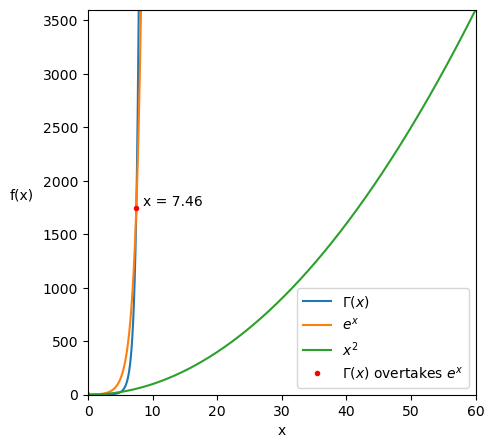

In [76]:
from scipy.special import gamma
from scipy.optimize import fsolve

xs = np.linspace(0,60,1000)
overtake = fsolve(lambda x: np.exp(x) - gamma(x), 10)[0]

plt.figure(figsize=(5,5))
plt.plot(xs, gamma(xs), label = r"$\Gamma(x)$")
plt.plot(xs, np.exp(xs), label = r"$e^x$")
plt.plot(xs, xs**2, label = r"$x^2$")
plt.plot(overtake, np.exp(overtake), 'r.', label = r"$\Gamma(x)$ overtakes $e^x$")
# Add padding to text so it doesn't overlap the curve
plt.text(overtake+1, np.exp(overtake), f"x = {overtake:.3g}", \
         va='bottom')
plt.ylim((0,max(xs**2)))
plt.xlim((min(xs),max(xs)))
plt.xlabel("x")
plt.ylabel("f(x)", rotation = 0, labelpad = 15)
plt.legend();

To reiterate, the normalization factor for the $\beta$-PDF is defined as $\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}$. At very low variances, however, $\alpha + \beta$ can become very large. The scipy package includes a method for computing the gamma function, ```scipy.special.gamma```. This function can only accept $\alpha+\beta \le 171$, which places a practical limit on the variances the $\beta$-PDF can handle.

Stirling's Approximation of the gamma function allows the derivation of a formula that approximates the normalization factor, allowing tolerance of variances approximately an order of magnitude smaller.

Stirling's Approximation for a factorial is defined as 
$$n! \approx \sqrt{2\pi}n^{\frac{1}{2} + n}e^{-n}$$
Applying this definition to the gamma function, 
$$\Gamma(n) = (n-1)! \approx \sqrt{2\pi}(n-1)^{n-\frac{1}{2}}e^{-(n-1)}$$
We can then rewrite the normalization factor using this approximation and simplify:
$$\text{norm} = \frac{\Gamma(\alpha + \beta)}{\Gamma({\alpha})\Gamma(\beta)} \approx \frac{\sqrt{2\pi}(\alpha+\beta-1)^{\alpha+\beta-\frac{1}{2}}e^{-(\alpha+\beta-1)}}{2\pi(\alpha-1)^{\alpha-\frac{1}{2}}e^{-(\alpha-1)}(\beta-1)^{\beta-\frac{1}{2}}e^{-(\beta-1)}}$$
$$= \frac{(\alpha+\beta-1)^{\alpha+\beta-\frac{1}{2}}e^{-(\alpha+\beta-1)}}{\sqrt{2\pi}(\alpha-1)^{\alpha-\frac{1}{2}}(\beta-1)^{\beta-\frac{1}{2}}e^{-(\alpha+\beta-2)}}$$
$$= \frac{(\alpha+\beta-1)^{\alpha+\beta-\frac{1}{2}}}{\sqrt{2\pi}e(\alpha-1)^{\alpha-\frac{1}{2}}(\beta-1)^{\beta-\frac{1}{2}}}$$
The quotient of exponentials can be more easily computed using exponentials:
$$\text{ln(norm)} = \left(\alpha+\beta-\frac{1}{2}\right)\text{ln}(\alpha+\beta-1) -\left(\alpha-\frac{1}{2}\right)\text{ln}(\alpha-1) - \left(\beta-\frac{1}{2}\right)\text{ln}(\beta-1)- \text{ln}(\sqrt{2\pi}e)$$

This approximation can compute the $\beta$-PDF normalization factor for $\alpha+\beta \le 1021$, thus allowing variances up to approximately an order of magnitude smaller. This result is shown graphically below.

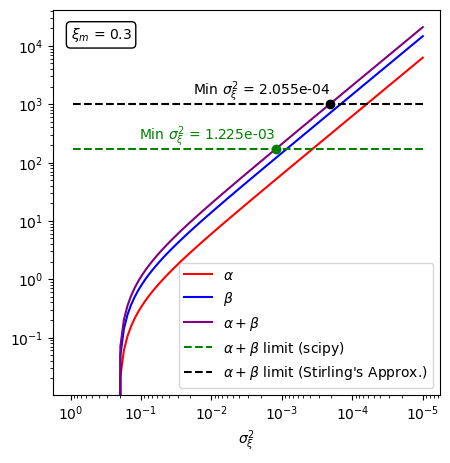

In [104]:
xim = 0.3 # Arbitrary
xiv = np.logspace(-5, 0, 100)
a = (xim)*(xim*(1-xim)/xiv - 1)
b = (1-xim)*(xim*(1-xim)/xiv - 1)

# Compute max variance for each version
aPlusbFunc = interp1d(xiv, a+b, kind='linear', fill_value='extrapolate', bounds_error=False)
maxScipy = fsolve(lambda x: aPlusbFunc(x) - 171, 0.001)[0]
maxStirling = fsolve(lambda x: aPlusbFunc(x) - 1021, 0.00025)[0]

plt.figure(figsize=(5,5))
plt.plot(xiv, a, 'r', label = r"$\alpha$")
plt.plot(xiv, b, 'b', label = r"$\beta$")
plt.plot(xiv, a+b, 'purple', label = r"$\alpha + \beta$")
plt.plot([min(xiv), max(xiv)], [171, 171], 'g--', label = r"$\alpha + \beta$ limit (scipy)")
plt.plot([min(xiv), max(xiv)], [1021, 1021], 'k--', label = r"$\alpha + \beta$ limit (Stirling's Approx.)")
plt.legend()
plt.text(maxScipy, 171, rf"Min $\sigma^2_{{\xi}}$ = {maxScipy:.3e}", \
         va='bottom', ha = 'right', color = 'g')
plt.text(maxStirling, 1021, rf"Min $\sigma^2_{{\xi}}$ = {maxStirling:.3e}", \
         va='bottom', ha = 'right')
plt.text(max(xiv), plt.gca().get_ylim()[1], rf"$\xi_m$ = {xim:.3g}", \
        va='top', ha = 'left',\
        bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle='round'))
plt.plot(maxScipy, 171, 'go')
plt.plot(maxStirling, 1021, 'ko')
plt.xlabel(r"$\sigma^2_{\xi}$")
plt.xscale('log')
plt.gca().invert_xaxis()
plt.yscale('log');

For variances lower than what even this approximation can handle, [Liu et. al.](https://www.semanticscholar.org/paper/A-robust-and-accurate-algorithm-of-the-β-pdf-and-to-Liu-Guoa/a5d8bf05c768d5f1bc72df6fa7b78aa6892105bc)[6] developed a method for integrating the $\beta$-PDF when $\alpha$ and $\beta$ are very large, specifically for combustion applications like ours. Thus, the current* TableMaker code implements all three. The code preferentially uses scipy, then stirling's approximation, then Liu et. al.'s method based on the computed values of $\alpha$ and $\beta$

*Nov. 20, 2024

## Note: Analogy of the $\beta$-PDF  to the Binomial Distribution
Understanding the $\beta$-PDF is helped by a conceptual understanding of other, simpler distributions. The binomial distribution is much simpler, but resembles the $\beta$ distribution. The binomial distribution describes the probability of success or failure in a repeated experiment with only 2 possible outcomes. Examples:
*  Simple: Coin toss. "How likely is it to toss heads 5/9 times? [4]
*  Complex: Sandwiche store. "If there's a 70% chance that someone buys a chicken sandwich at Subway, what's the probability that 2 of the 3 next customers buy a chicken sandwich?" [4]

The probability distribution can be logically derived:
* Probability of a success occuring (with likelihood $p$) $k$ times = $p^k$
* Probability of a failure occuring (with likelihood $(1-p)$) the rest of the times in $n$ trials = $(1-p)^{(n-k)}$
* Thus, the combined probability of this scenario occuring = $p^k(1-p)^{(n-k)}$, where
    * **p** is the probability of the desired outcome
    * **k** is the number of successful trials
    * **n** is the total number of trials
* However, this does not account for the fact that there are multiple ways to achieve this result. For example, to get 2 successes (S) and 1 failure (F), we might have:

<center>

|Trial 1 |Trial 2 |Trial 3 |Probability of occurence |
|-------|-------|-------|------------------------|
|S|S|F|$p^2(1-p)^{(3-2)}$|
|S|F|S|$p^2(1-p)^{(3-2)}$|
|F|S|S|$p^2(1-p)^{(3-2)}$|

</center>

* Therefore, the actual total probability for 2/3 successes should be $P = 3p^2(1-p)^{(3-2)}$
* The value of this coefficient is known as the binomial coefficient. It expresses the number of possible scenarios that result in the desired outcome. It is defined as ${n \choose k} = \frac{n!}{k!(n-k)!} $ where
    * **k** is the number of outcomes we're selecting (2) from
    * **n** the total number of outcomes (3)

* Thus, we arrive at the full formula for the binomial distribution:
$$P(\mathrm{k~out~of~n}) = \frac{n!}{k!(n-k)!}p^k(1-p)^{(n-k)}$$

* We can also note here that the variance of the distribution is $\sigma^2 = np(1-p)$



## *Sources:*
[1] https://en.wikipedia.org/wiki/Beta_distribution

[2] https://en.wikipedia.org/wiki/Beta_function

[3] https://en.wikipedia.org/wiki/Gamma_function

[4] https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af

[5] https://homepage.divms.uiowa.edu/~mbognar/applets/beta.html

[6] Liu, F. et al. “A robust and accurate algorithm of the β-pdf integration and its application to turbulent methane – air diffusion combustion in a gas turbine combustor simulator.” (2002).